In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / "src"))

from network_simulators.feedforward_current_based.simulator import (
    FeedforwardCurrentLIFNetwork,
)

## Setup Parameters

Define network architecture and biological time constants.

In [2]:
# Network architecture
n_inputs = 100
n_neurons = 200
batch_size = 1

# Simulation parameters
dt = 1e-3  # 1 ms timestep
n_steps = 1000  # 1 second simulation

# Biological time constants (in seconds)
tau_mem = 20e-3  # 20 ms membrane time constant
tau_syn = 5e-3  # 5 ms synaptic time constant

# Decay factors (from tau = -dt / log(decay))
beta_mem = np.exp(-dt / tau_mem)  # ~0.951
alpha_syn = np.exp(-dt / tau_syn)  # ~0.819

print(f"Membrane decay factor (beta_mem): {beta_mem:.4f}")
print(f"Synaptic decay factor (alpha_syn): {alpha_syn:.4f}")

Membrane decay factor (beta_mem): 0.9512
Synaptic decay factor (alpha_syn): 0.8187


## Create Weight Matrix

Generate a random sparse weight matrix with some structure.

In [3]:
# Create weight matrix (100 inputs -> 200 neurons)
# Use sparse connectivity (~10% connection probability)
connection_prob = 0.05
weight_scale = 0.5  # Scale weights appropriately for natural units

# Random sparse connectivity - weights must be POSITIVE (sign comes from synapse type)
np.random.seed(42)
weights_FF = np.abs(np.random.randn(n_inputs, n_neurons)) * weight_scale
mask = np.random.rand(n_inputs, n_neurons) < connection_prob
weights_FF = weights_FF * mask

print(f"Weight matrix shape: {weights_FF.shape}")
print(f"Connection density: {mask.mean():.2%}")
print(f"Mean weight: {weights_FF[mask].mean():.4f}")
print(f"Weight std: {weights_FF[mask].std():.4f}")

Weight matrix shape: (100, 200)
Connection density: 4.92%
Mean weight: 0.4056
Weight std: 0.3076


## Generate Input Spike Trains

Create Poisson-distributed input spikes with varying rates.

In [4]:
# Generate input spikes with Poisson statistics
# Input rates vary from 5 Hz to 20 Hz across neurons
input_rates = np.linspace(5, 20, n_inputs)  # Hz
input_prob = input_rates * dt  # Spike probability per timestep

# Generate spikes: shape (batch_size, n_steps, n_inputs)
np.random.seed(123)
input_spikes = (np.random.rand(batch_size, n_steps, n_inputs) < input_prob).astype(
    np.float32
)

print(f"Input spikes shape: {input_spikes.shape}")
print(f"Mean input firing rate: {input_spikes.mean() / dt:.2f} Hz")
print(f"Total input spikes: {input_spikes.sum():.0f}")

Input spikes shape: (1, 1000, 100)
Mean input firing rate: 11.84 Hz
Total input spikes: 1184


## Initialize Network

Create the feedforward current-based LIF network with tracking enabled.

In [5]:
# Cell type indices for postsynaptic neurons (all excitatory)
cell_type_indices = np.zeros(n_neurons, dtype=int)

# Cell type indices for inputs: 80% excitatory (type 0), 20% inhibitory (type 1)
n_excitatory_inputs = int(0.8 * n_inputs)
cell_type_indices_FF = np.zeros(n_inputs, dtype=int)
cell_type_indices_FF[n_excitatory_inputs:] = 1  # Last 20% are inhibitory

print(
    f"Input neurons: {n_excitatory_inputs} excitatory, {n_inputs - n_excitatory_inputs} inhibitory"
)

# Create cell parameters dictionary (required format)
# Convert time constants from seconds to milliseconds
tau_mem_ms = tau_mem * 1000  # 20 ms
tau_ref_ms = 2.0  # 2 ms refractory period

# Note: tau_syn is now in synapse_params_FF, not cell_params
cell_params = [
    {
        "name": "excitatory",
        "cell_id": 0,
        "tau_mem": tau_mem_ms,
        "tau_ref": tau_ref_ms,
    }
]

# Create synapse parameters for feedforward connections
# One synapse type per input cell type
tau_syn_ms = tau_syn * 1000  # 5 ms
tau_syn_inh_ms = 10.0  # Inhibitory synapses are slower

synapse_params_FF = [
    {
        "name": "excitatory",
        "synapse_id": 0,
        "cell_id": 0,  # From excitatory input cells
        "tau_syn": tau_syn_ms,
        "type": "excitatory",
    },
    {
        "name": "inhibitory",
        "synapse_id": 1,
        "cell_id": 1,  # From inhibitory input cells
        "tau_syn": tau_syn_inh_ms,
        "type": "inhibitory",
    },
]

# Initialize network with tracking enabled
network = FeedforwardCurrentLIFNetwork(
    dt=dt * 1000,  # Convert to milliseconds
    weights_FF=weights_FF,  # Pass numpy array, not torch tensor (must be positive)
    cell_type_indices=cell_type_indices,
    cell_type_indices_FF=cell_type_indices_FF,
    cell_params=cell_params,
    synapse_params_FF=synapse_params_FF,
    batch_size=batch_size,
    optimisable="weights",  # Make weights trainable
    feedforward_mask=mask,  # Required when optimisable="weights"
    track_variables=True,  # Track all variables for visualization
    use_tqdm=True,  # Show progress bar
    surrgrad_scale=10.0,  # Surrogate gradient scale
)

print(f"Network initialized: {n_inputs} inputs -> {n_neurons} neurons")
print(f"Device: {network.device}")

Input neurons: 80 excitatory, 20 inhibitory
Network initialized: 100 inputs -> 200 neurons
Device: cpu


## Run Simulation

Execute the network simulation and collect outputs.

In [6]:
# Reset state before simulation
network.reset_state(batch_size=batch_size)

# Run simulation
with torch.no_grad():  # No gradients needed for testing
    outputs = network.forward(input_spikes)

# Extract outputs
spikes = outputs["spikes"].cpu().numpy()
voltages = outputs["voltages"].cpu().numpy()
currents = outputs["currents_syn"].cpu().numpy()

print("Simulation complete!")
print(f"Output spikes shape: {spikes.shape}")
print(f"Total output spikes: {spikes.sum():.0f}")
print(f"Mean output firing rate: {spikes.mean() / dt:.2f} Hz")

Simulating feedforward network: 100%|██████████| 1000/1000 [00:00<00:00, 2905.68step/s]

Simulation complete!
Output spikes shape: (1, 1000, 200)
Total output spikes: 7283
Mean output firing rate: 36.41 Hz


## Visualize Results

Plot input spikes, output spikes, membrane potentials, and synaptic currents.

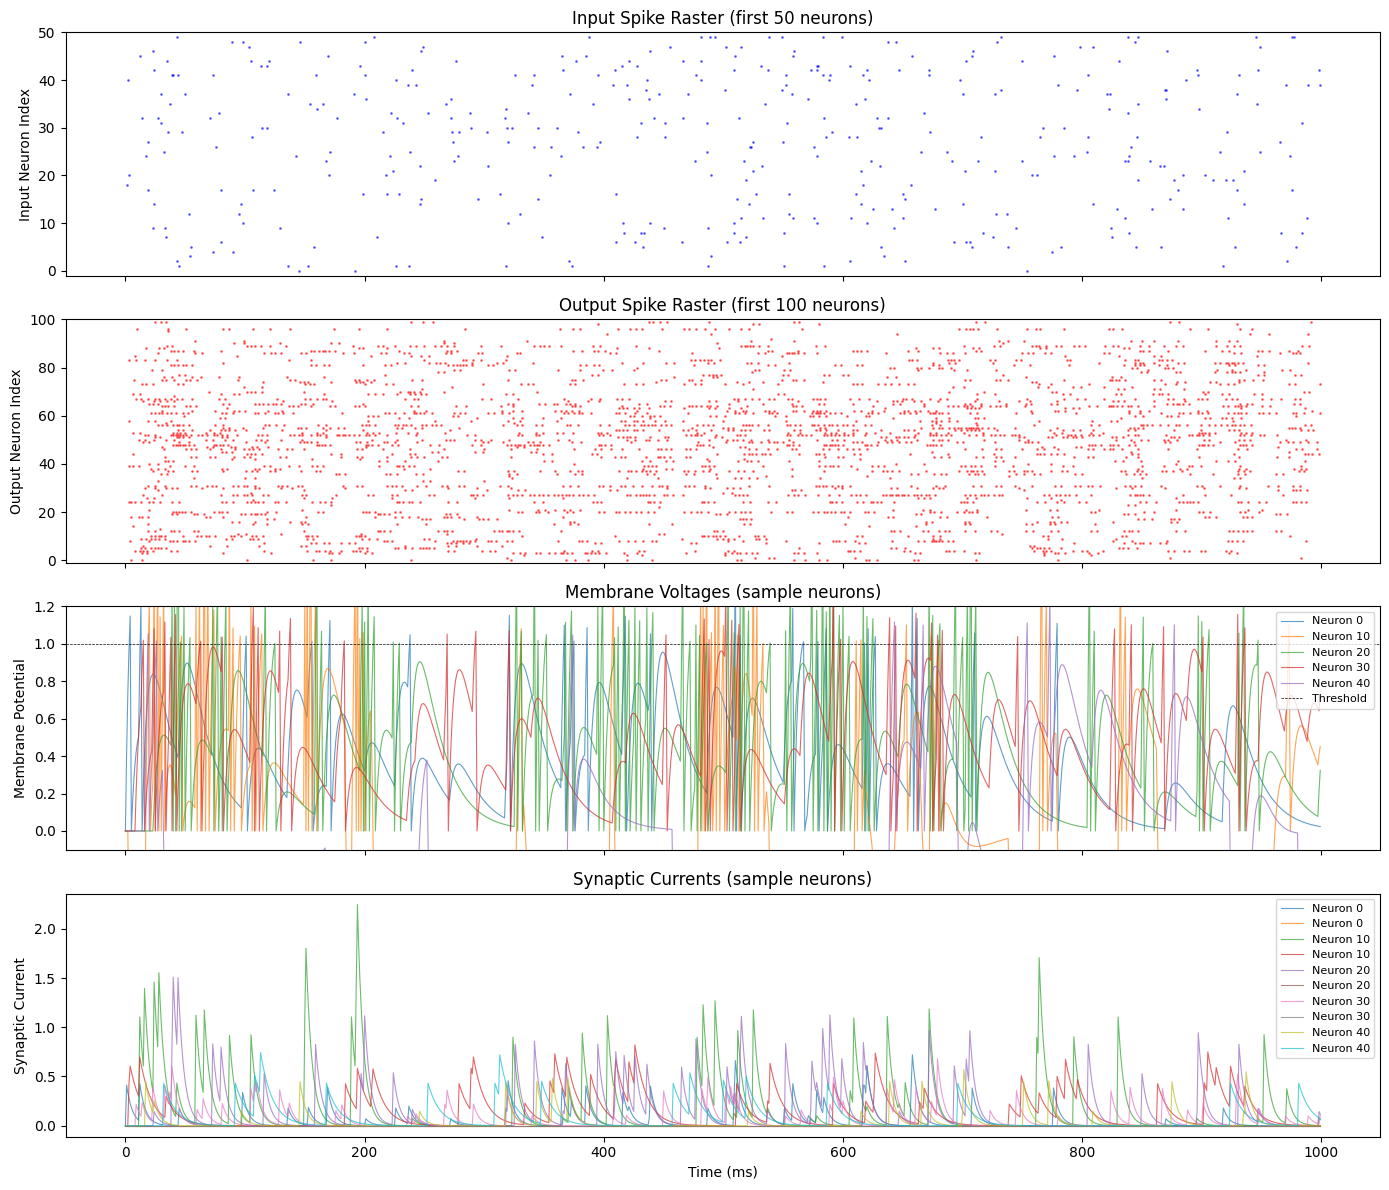

In [7]:
# Create time array
time_ms = np.arange(n_steps) * dt * 1000  # Convert to ms

# Create figure with subplots
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Plot 1: Input spike raster
ax = axes[0]
for neuron_idx in range(min(50, n_inputs)):  # Show first 50 inputs
    spike_times = time_ms[input_spikes[0, :, neuron_idx] > 0]
    ax.scatter(spike_times, [neuron_idx] * len(spike_times), s=1, c="blue", alpha=0.5)
ax.set_ylabel("Input Neuron Index")
ax.set_title("Input Spike Raster (first 50 neurons)")
ax.set_ylim(-1, 50)

# Plot 2: Output spike raster
ax = axes[1]
for neuron_idx in range(min(100, n_neurons)):  # Show first 100 outputs
    spike_times = time_ms[spikes[0, :, neuron_idx] > 0]
    ax.scatter(spike_times, [neuron_idx] * len(spike_times), s=1, c="red", alpha=0.5)
ax.set_ylabel("Output Neuron Index")
ax.set_title("Output Spike Raster (first 100 neurons)")
ax.set_ylim(-1, 100)

# Plot 3: Membrane voltages (sample neurons)
ax = axes[2]
sample_neurons = [0, 10, 20, 30, 40]  # Sample 5 neurons
for neuron_idx in sample_neurons:
    ax.plot(
        time_ms,
        voltages[0, :, neuron_idx],
        alpha=0.7,
        linewidth=0.8,
        label=f"Neuron {neuron_idx}",
    )
ax.axhline(1.0, color="black", linestyle="--", linewidth=0.5, label="Threshold")
ax.set_ylabel("Membrane Potential")
ax.set_title("Membrane Voltages (sample neurons)")
ax.legend(loc="upper right", fontsize=8)
ax.set_ylim(-0.1, 1.2)

# Plot 4: Synaptic currents (same sample neurons)
ax = axes[3]
for neuron_idx in sample_neurons:
    ax.plot(
        time_ms,
        currents[0, :, neuron_idx],
        alpha=0.7,
        linewidth=0.8,
        label=f"Neuron {neuron_idx}",
    )
ax.set_ylabel("Synaptic Current")
ax.set_xlabel("Time (ms)")
ax.set_title("Synaptic Currents (sample neurons)")
ax.legend(loc="upper right", fontsize=8)

plt.tight_layout()
plt.show()

## Analyze Firing Statistics

Compute firing rate distributions and connectivity statistics.

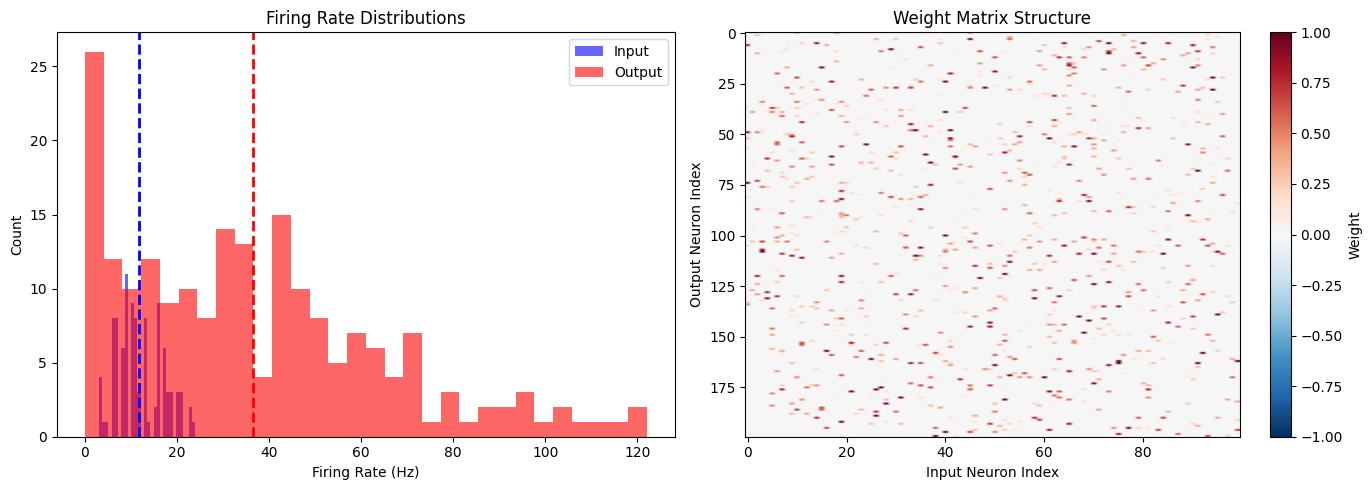


=== Firing Rate Statistics ===
Input: mean=11.84 Hz, std=5.06 Hz
Output: mean=36.42 Hz, std=28.37 Hz

Silent output neurons: 9/200


In [8]:
# Calculate per-neuron firing rates
input_firing_rates = input_spikes.sum(axis=1) / (
    n_steps * dt
)  # Shape: (batch_size, n_inputs)
output_firing_rates = spikes.sum(axis=1) / (
    n_steps * dt
)  # Shape: (batch_size, n_neurons)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Firing rate distributions
ax = axes[0]
ax.hist(input_firing_rates[0], bins=30, alpha=0.6, label="Input", color="blue")
ax.hist(output_firing_rates[0], bins=30, alpha=0.6, label="Output", color="red")
ax.set_xlabel("Firing Rate (Hz)")
ax.set_ylabel("Count")
ax.set_title("Firing Rate Distributions")
ax.legend()
ax.axvline(
    input_firing_rates[0].mean(),
    color="blue",
    linestyle="--",
    linewidth=2,
    label="Input mean",
)
ax.axvline(
    output_firing_rates[0].mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label="Output mean",
)

# Plot 2: Weight matrix structure
ax = axes[1]
im = ax.imshow(weights_FF.T, aspect="auto", cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_xlabel("Input Neuron Index")
ax.set_ylabel("Output Neuron Index")
ax.set_title("Weight Matrix Structure")
plt.colorbar(im, ax=ax, label="Weight")

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Firing Rate Statistics ===")
print(
    f"Input: mean={input_firing_rates[0].mean():.2f} Hz, std={input_firing_rates[0].std():.2f} Hz"
)
print(
    f"Output: mean={output_firing_rates[0].mean():.2f} Hz, std={output_firing_rates[0].std():.2f} Hz"
)
print(f"\nSilent output neurons: {(output_firing_rates[0] == 0).sum()}/{n_neurons}")

## Test Chunked Simulation

Test that state continues properly across multiple forward calls.

In [9]:
# Reset network
network.reset_state(batch_size=batch_size)
network.track_variables = False  # Don't track for chunked simulation

# Split input into 4 chunks
chunk_size = n_steps // 4
output_chunks = []

print("Running chunked simulation...")
with torch.no_grad():
    for i in range(4):
        start_idx = i * chunk_size
        end_idx = start_idx + chunk_size
        chunk_input = input_spikes[:, start_idx:end_idx, :]
        chunk_output = network.forward(chunk_input)
        output_chunks.append(chunk_output.cpu().numpy())
        print(f"Chunk {i + 1}/4: {chunk_output.sum():.0f} spikes")

# Concatenate chunks
spikes_chunked = np.concatenate(output_chunks, axis=1)

# Compare with original full simulation
print("\n=== Chunked Simulation Comparison ===")
print(f"Original simulation: {spikes.sum():.0f} total spikes")
print(f"Chunked simulation: {spikes_chunked.sum():.0f} total spikes")
print(f"Difference: {abs(spikes.sum() - spikes_chunked.sum()):.0f} spikes")
print("Note: Differences expected due to state initialization and boundary effects")

Running chunked simulation...


Simulating feedforward network: 100%|██████████| 250/250 [00:00<00:00, 3338.72step/s]


Chunk 1/4: 1892 spikes


Simulating feedforward network: 100%|██████████| 250/250 [00:00<00:00, 3487.48step/s]


Chunk 2/4: 1678 spikes


Simulating feedforward network: 100%|██████████| 250/250 [00:00<00:00, 2559.31step/s]


Chunk 3/4: 1952 spikes


Simulating feedforward network: 100%|██████████| 250/250 [00:00<00:00, 3519.44step/s]

Chunk 4/4: 1761 spikes

=== Chunked Simulation Comparison ===
Original simulation: 7283 total spikes
Chunked simulation: 7283 total spikes
Difference: 0 spikes
Note: Differences expected due to state initialization and boundary effects
